# Smart Meters

This notebook is an example on how to use the Vertica ML Python Library. We will use the Smart Meters dataset to predict user electricity consumption. You can download the Jupyter Notebook of the study by clicking <a href="smart_meters.ipynb">here</a>. To achieve our goals, we have access to 3 datasets.

<b>sm_consumption</b> (Click <a href="../../data/smart_meters/sm_consumption.csv">here</a> to download the dataset)
<ul>
    <li><b>dateUTC: </b>Datetime of the record</li>
    <li><b>meterID: </b>Smart Meter ID</li>
    <li><b>value: </b>Smart Meter consumption</li>
</ul>

<b>sm_weather</b> (Click <a href="../../data/smart_meters/sm_weather.csv">here</a> to download the dataset)
<ul>
    <li><b>dateUTC: </b>Datetime of the record</li>
    <li><b>temperature: </b>Temperature</li>
    <li><b>humidity: </b>Humidity</li>
</ul>

<b>sm_meters</b> (Click <a href="../../data/smart_meters/sm_meters.csv">here</a> to download the dataset)
<ul>
    <li><b>longitude: </b>Longitude</li>
    <li><b>latitude: </b>Latitude</li>
    <li><b>residenceType: </b>1 for Single-Family; 2 for Multi-Family; 3 for Appartement</li>
</ul>

We will follow the entire Data Science cycle (Data Exploration - Data Preparation - Data Modeling - Model Evaluation - Model Deployment) and solve this easy use-case. The purpose is to show you some of the library interesting functionalities.


## Initialization

Let's create the Virtual DataFrames of the datasets.

In [1]:
from vertica_ml_python import *
sm_consumption = vDataFrame("sm_consumption")
sm_weather = vDataFrame("sm_weather")
sm_meters = vDataFrame("sm_meters")
print(sm_consumption)
print(sm_weather)
print(sm_meters)

,meterID,value,dateUTC
0,882,0.055,2014-05-09 11:30:00
1,882,0.2,2014-05-10 15:15:00
2,882,0.04,2014-05-11 04:15:00
3,882,0.036,2014-05-11 08:00:00
4,882,0.074,2014-05-11 12:30:00
,...,...,...


<object>  Name: sm_consumption, Number of rows: 1188432, Number of columns: 3


,temperature,dateUTC,humidity
0,38.0,2014-01-01 00:00:00,95.0
1,37.4,2014-01-01 00:30:00,93.0
2,37.4,2014-01-01 01:00:00,100.0
3,37.4,2014-01-01 01:30:00,100.0
4,39.2,2014-01-01 02:00:00,93.0
,...,...,...


<object>  Name: sm_weather, Number of rows: 35036, Number of columns: 3


,residenceType,latitude,longitude,meterID
0,1,53.3575915882838,-6.27554509198069,0
1,1,53.3130886440828,-6.21174062227953,1
2,1,53.322863954253,-6.25885396251447,2
3,3,51.895226209818,-8.54531304761961,3
4,1,53.6511753623331,-6.69348712237822,4
,...,...,...,...


<object>  Name: sm_meters, Number of rows: 1000, Number of columns: 4


## Data Exploration and Preparation

Predicting energy consumption in households can be very important as too much electricity consumptions at the same moment could lead to general power failure. The data are gathering many UK housings electricity consumptions. 

In order to join the different data sources, we need to assume that the weather will be approximately the same in all the UK. Indeed, the key to join 'sm_weather' and 'sm_consumption' will be the datetime. 

We can interpolate each hour of the two datasets using linear interpolation to simplify the joins.

In [2]:
sm_weather = sm_weather.asfreq(ts = "dateUTC",
                               rule = "1 hour",
                               method = {"temperature": "linear",
                                         "humidity" : "linear"})
sm_consumption = sm_consumption.asfreq(ts = "dateUTC",
                                       rule = "1 hour",
                                       method = {"value": "linear"},
                                       by = ["meterID"])

We can join the two datasets.

In [3]:
sm_consumption_weather = sm_consumption.join(
                            sm_weather,
                            how = "natural",
                            expr1 = ["dateUTC", "meterID", "value"],
                            expr2 = ["humidity", "temperature"])
print(sm_consumption_weather)

,dateUTC,meterID,value,humidity,temperature
0,2014-01-23 21:00:00,0,0.226,87.0,35.6
1,2014-01-23 22:00:00,0,0.2058,93.0,33.8
2,2014-01-23 23:00:00,0,0.1856,87.0,35.6
3,2014-01-24 00:00:00,0,0.1654,88.0,35.0
4,2014-01-24 01:00:00,0,0.1452,93.0,35.6
,...,...,...,...,...


<object>  Name: join, Number of rows: 14818143, Number of columns: 5


As the operations are expensive, we can export the result to the Vertica DataBase. 

In [4]:
drop_table("sm_consumption_weather")
sm_consumption_weather.to_db("sm_consumption_weather", 
                             relation_type = "table",
                             inplace = True)

The table sm_consumption_weather was successfully dropped.


,dateUTC,temperature,humidity,value,meterID
0,2014-04-21 10:00:00,53.6,82.0,0.375734265734266,412
1,2014-04-21 11:00:00,53.6,82.0,0.373496503496503,412
2,2014-04-21 12:00:00,57.2,67.0,0.371258741258741,412
3,2014-04-21 13:00:00,58.0,56.0,0.369020979020979,412
4,2014-04-21 14:00:00,59.0,67.0,0.366783216783217,412
,...,...,...,...,...


<object>  Name: sm_consumption_weather, Number of rows: 14818143, Number of columns: 5

The dataset 'sm_meters' can bring relevant information. First, the Residence Type can be a good predictor. We can also create clusters of the different regions using a KMeans based on longitude and latitude. Let's find the most suitable K using an Elbow Curve and a Scatter Plot. 

In [5]:
sm_meters.agg(["min", "max"])

,min,max
"""residenceType""",1.0,3.0
"""latitude""",51.7964600770212,54.0270361317983
"""longitude""",-9.16352332036362,-6.07134572494937
"""meterID""",0.0,999.0


<object>

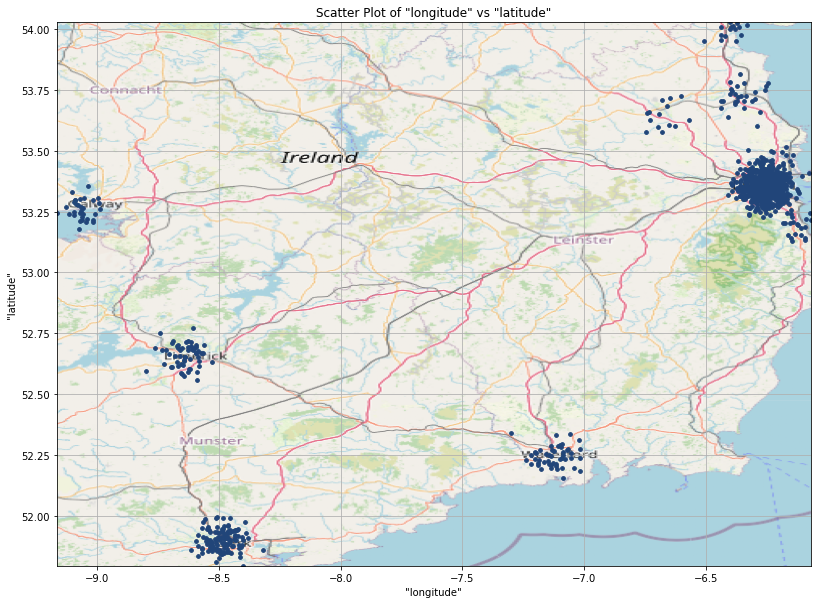

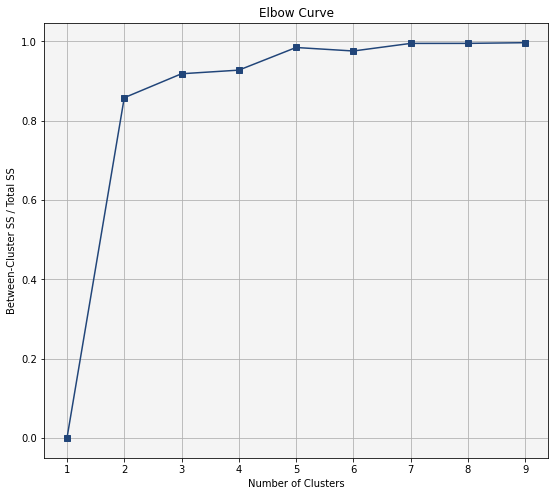

In [8]:
%matplotlib inline
from vertica_ml_python.learn.plot import elbow
sm_meters.scatter(["longitude", "latitude"], img = "img/ireland.png")
x = elbow(["longitude", "latitude"], "sm_meters", n_cluster = (1, 10))

6 is an optimal number of clusters (we can see it clearly in both the Elbow Curve and the Scatter Plot). Let's create a KMeans model with 6 clusters.

In [39]:
drop_model("kmeans_sm_regions")

from vertica_ml_python.learn.cluster import KMeans
model = KMeans("kmeans_sm_regions", n_cluster = 6)
model.fit("sm_meters", ["longitude", "latitude"])

The model kmeans_sm_regions was successfully dropped.




centers
longitude|latitude
---------+--------
-8.48641 |51.90216
-6.25519 |53.34870
-9.06178 |53.25998
-7.12408 |52.24610
-8.63985 |52.65945
-6.44536 |53.77273


metrics
Evaluation metrics:
     Total Sum of Squares: 1209.2077
     Within-Cluster Sum of Squares: 
         Cluster 0: 0.53464463
         Cluster 1: 4.2455176
         Cluster 2: 0.099754154
         Cluster 3: 0.2657853
         Cluster 4: 0.2779225
         Cluster 5: 2.2820833
     Total Within-Cluster Sum of Squares: 7.7057075
     Between-Cluster Sum of Squares: 1201.502
     Between-Cluster SS / Total SS: 99.36%
 Number of iterations performed: 2
 Converged: True
 Call:
kmeans('public.kmeans_sm_regions', 'sm_meters', '"longitude", "latitude"', 6
USING PARAMETERS max_iterations=300, epsilon=0.0001, init_method='kmeanspp', distance_method='euclidean')

Let's add our clusters to our vDataFrame.

In [40]:
model.predict(sm_meters, name = "region")

,residenceType,latitude,longitude,meterID,region
0,1,53.3575915882838,-6.27554509198069,0,1
1,1,53.3130886440828,-6.21174062227953,1,1
2,1,53.322863954253,-6.25885396251447,2,1
3,3,51.895226209818,-8.54531304761961,3,0
4,1,53.6511753623331,-6.69348712237822,4,5
,...,...,...,...,...


<object>  Name: sm_meters, Number of rows: 1000, Number of columns: 5

Let's draw the Scatter Plot of the different regions.

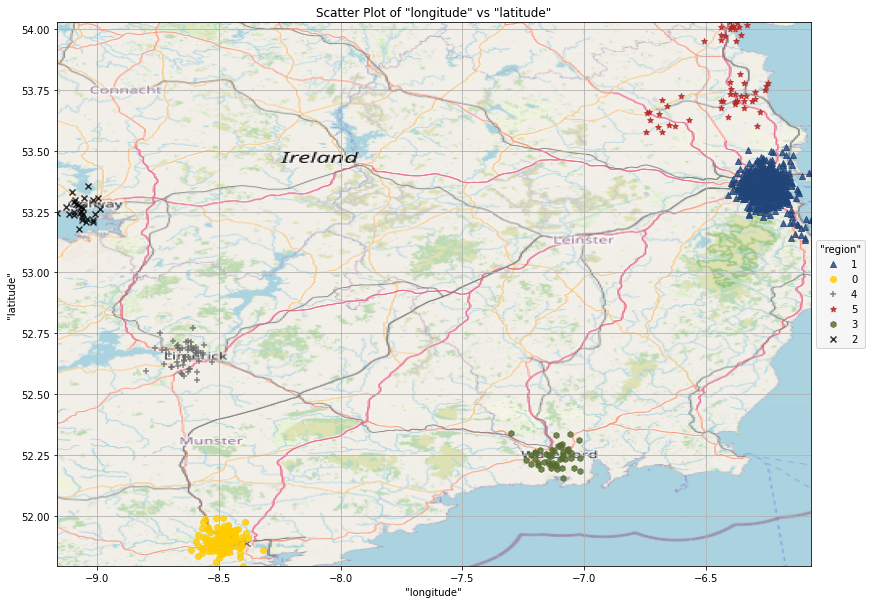

In [41]:
x = sm_meters.scatter(["longitude", "latitude"], 
                      catcol = "region",
                      max_cardinality = 10,
                      img = "img/ireland.png")

Let's join 'sm_meters' with 'sm_consumption_weather'.

In [42]:
sm_consumption_weather_region = sm_consumption_weather.join(
                                    sm_meters,
                                    how = "natural",
                                    expr1 = ["*"],
                                    expr2 = ["residenceType", 
                                             "region"])
print(sm_consumption_weather_region)

,dateUTC,meterID,value,humidity,temperature,residenceType,region
0,2015-08-18 16:00:00,482,0.0735657894736842,68.0,64.4,1,3
1,2015-08-18 17:00:00,482,0.0728815789473684,82.0,59.0,1,3
2,2015-08-18 18:00:00,482,0.0721973684210526,77.0,59.0,1,3
3,2015-08-18 19:00:00,482,0.0715131578947368,73.0,59.0,1,3
4,2015-08-18 20:00:00,482,0.0709189189189189,82.0,59.0,1,3
,...,...,...,...,...,...,...


<object>  Name: join, Number of rows: 14818143, Number of columns: 7


As joins are expensive, we can save our dataset in the Vertica DataBase.

In [43]:
drop_table("sm_consumption_weather_region")
sm_consumption_weather_region.to_db("sm_consumption_weather_region", 
                                     relation_type = "table",
                                     inplace = True)

The table sm_consumption_weather_region was successfully dropped.


,region,value,meterID,residenceType,dateUTC,temperature,humidity
0,0,0.1352,309,1,2014-03-24 22:00:00,48.2,87.0
1,0,0.129651063829787,309,1,2014-03-24 23:00:00,46.4,76.0
2,0,0.124102127659574,309,1,2014-03-25 00:00:00,45.0,69.0
3,0,0.118553191489362,309,1,2014-03-25 01:00:00,44.6,87.0
4,0,0.113004255319149,309,1,2014-03-25 02:00:00,42.8,87.0
,...,...,...,...,...,...,...


<object>  Name: sm_consumption_weather_region, Number of rows: 14818143, Number of columns: 7

Let's look at the missing values.

In [44]:
sm_consumption_weather_region.count()

,count,percent
"""region""",14818143.0,100.0
"""meterID""",14818143.0,100.0
"""residenceType""",14818143.0,100.0
"""dateUTC""",14818143.0,100.0
"""temperature""",14818143.0,100.0
"""humidity""",14818143.0,100.0
"""value""",14816843.0,99.991


<object>

The variable 'value' has few missing values that we can drop.

In [45]:
sm_consumption_weather_region["value"].dropna()

1300 element(s) was/were filtered


,region,value,meterID,residenceType,dateUTC,temperature,humidity
0,0,0.1352,309,1,2014-03-24 22:00:00,48.2,87.0
1,0,0.129651063829787,309,1,2014-03-24 23:00:00,46.4,76.0
2,0,0.124102127659574,309,1,2014-03-25 00:00:00,45.0,69.0
3,0,0.118553191489362,309,1,2014-03-25 01:00:00,44.6,87.0
4,0,0.113004255319149,309,1,2014-03-25 02:00:00,42.8,87.0
,...,...,...,...,...,...,...


<object>  Name: sm_consumption_weather_region, Number of rows: 14816843, Number of columns: 7

General Power Failure is happening most of the time per area. That's why, a good idea could be to get the average consumption per region.

In [46]:
sm_consumption_weather_region = sm_consumption_weather_region.groupby(
                    columns = ["region", 
                               "residenceType", 
                               "dateUTC"],
                    expr = ["AVG(value) AS avg_value",
                            "AVG(temperature) AS temperature",
                            "AVG(humidity) AS humidity"])

A natural idea is to compute the cumulative sum of the electricity consumption of each region and residence Type.

In [47]:
sm_consumption_weather_region.cumsum(column = "avg_value",
                                     by = ["region", "residenceType"],
                                     order_by = ["dateUTC"],
                                     name = "cum_value")

,region,residenceType,dateUTC,avg_value,temperature,humidity,cum_value
0,0,1,2014-01-01 00:00:00,0.152,38.0,95.0,0.152
1,0,1,2014-01-01 01:00:00,0.257445578231292,37.4,100.0,0.409445578231292
2,0,1,2014-01-01 02:00:00,0.207876238046406,39.2,93.0,0.617321816277699
3,0,1,2014-01-01 03:00:00,0.284470740335182,39.2,93.0,0.90179255661288
4,0,1,2014-01-01 04:00:00,0.169127598285197,39.2,93.0,1.07092015489808
,...,...,...,...,...,...,...


<object>  Name: groupby, Number of rows: 267141, Number of columns: 7

The linearity will be clearly visible.

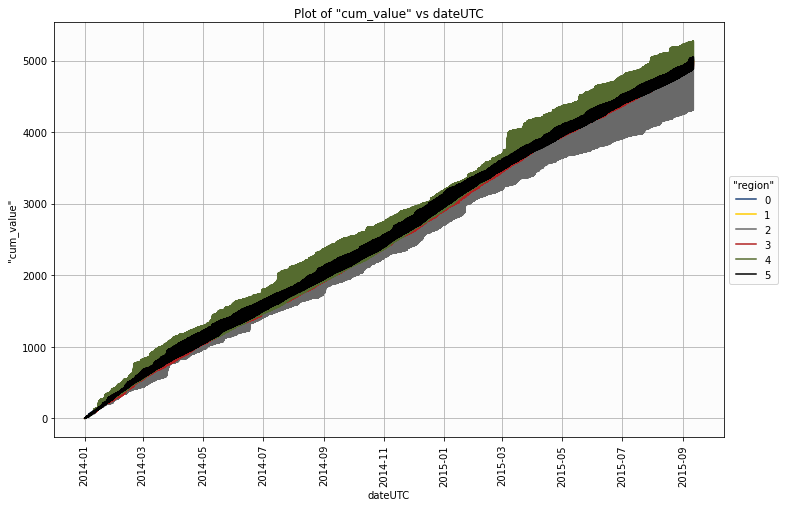

In [48]:
x = sm_consumption_weather_region["cum_value"].plot(ts = "dateUTC",
                                                    by = "region")

Many relevant features can be created. For example, we can create dummies of the categorical features, extract the year quarter and compute the elapsed time.

In [49]:
sm_consumption_weather_region.eval(name = "quarter", 
                                   expr = "QUARTER(dateUTC)")
sm_consumption_weather_region.get_dummies(columns = ["residenceType",
                                                     "region",
                                                     "quarter"],
                                          max_cardinality = 20,
                                          drop_first = False)
sm_consumption_weather_region.eval(
    name = "elapsed_time", 
    expr = "TIMESTAMPDIFF(HOUR, MIN(dateUTC) OVER (), dateUTC)")

,region,residenceType,dateUTC,avg_value,temperature,humidity,cum_value,quarter,residenceType_1,residenceType_2,residenceType_3,region_0,region_1,region_2,region_3,region_4,region_5,quarter_1,quarter_2,quarter_3,quarter_4,elapsed_time
0,0,1,2014-01-01 00:00:00,0.152,38.0,95.0,0.152,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0
1,0,1,2014-01-01 01:00:00,0.257445578231292,37.4,100.0,0.409445578231292,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1
2,0,1,2014-01-01 02:00:00,0.207876238046406,39.2,93.0,0.617321816277699,1,1,0,0,1,0,0,0,0,0,1,0,0,0,2
3,0,1,2014-01-01 03:00:00,0.284470740335182,39.2,93.0,0.90179255661288,1,1,0,0,1,0,0,0,0,0,1,0,0,0,3
4,0,1,2014-01-01 04:00:00,0.169127598285197,39.2,93.0,1.07092015489808,1,1,0,0,1,0,0,0,0,0,1,0,0,0,4
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: groupby, Number of rows: 267141, Number of columns: 22

Let's export our final dataset to the Vertica DataBase.

In [50]:
drop_table("sm_final")
sm_consumption_weather_region.to_db(name = "sm_final",
                                    relation_type = "table",
                                    inplace = True)

The table sm_final was successfully dropped.


,avg_value,quarter_4,residenceType,dateUTC,residenceType_3,temperature,cum_value,residenceType_1,region_1,quarter_1,region_5,quarter,region,region_0,region_4,quarter_3,humidity,quarter_2,residenceType_2,region_3,elapsed_time,region_2
0,0.152,0,1,2014-01-01 00:00:00,0,38.0,0.152,1,0,1,0,1,0,1,0,0,95.0,0,0,0,0,0
1,0.257445578231292,0,1,2014-01-01 01:00:00,0,37.4,0.409445578231292,1,0,1,0,1,0,1,0,0,100.0,0,0,0,1,0
2,0.207876238046406,0,1,2014-01-01 02:00:00,0,39.2,0.617321816277699,1,0,1,0,1,0,1,0,0,93.0,0,0,0,2,0
3,0.284470740335182,0,1,2014-01-01 03:00:00,0,39.2,0.90179255661288,1,0,1,0,1,0,1,0,0,93.0,0,0,0,3,0
4,0.169127598285197,0,1,2014-01-01 04:00:00,0,39.2,1.07092015489808,1,0,1,0,1,0,1,0,0,93.0,0,0,0,4,0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: sm_final, Number of rows: 267141, Number of columns: 22

We can look at the correlation between our response and the predictors.

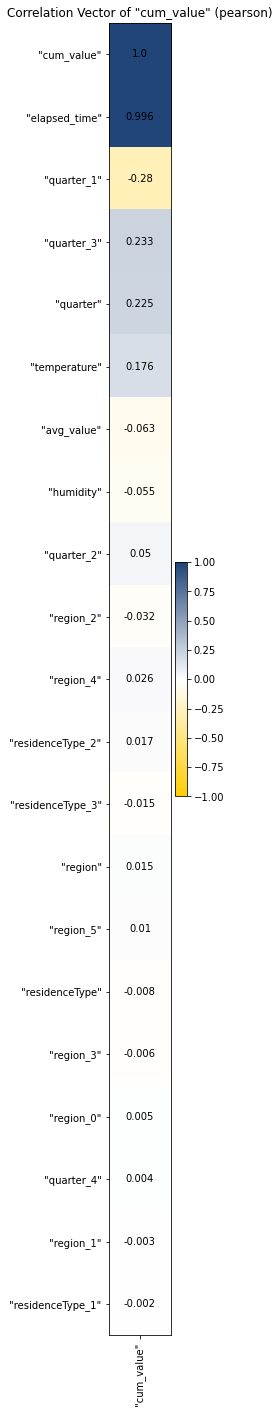

In [51]:
x = sm_consumption_weather_region.corr(focus = "cum_value")

We can see a very high correlation between the cumulative sum and the elapsed time. Some other features are also correlated (Ex: quarter_1, quarter_3 and temperature)

## Machine Learning

Let's create our model.

In [52]:
from vertica_ml_python.learn.linear_model import LinearRegression
from vertica_ml_python.learn.model_selection import cross_validate
from vertica_ml_python.utilities import drop_model

predictors = ["elapsed_time",
              "quarter_1",
              "quarter_3",
              "temperature",
              "humidity"]
response = "cum_value"
relation = "sm_final"
drop_model("sm_lr")
model = LinearRegression("sm_lr", solver = "BFGS")
cross_validate(model, relation, predictors, response, cv = 3)

The model sm_lr was successfully dropped.


,explained_variance,max_error,median_absolute_error,mean_absolute_error,mean_squared_error,r2
1-fold,0.992907771077666,683.073856347505,47.4843777076771,76.5186038889017,14608.7432326017,0.992907770793794
2-fold,0.992893758927634,681.51930692058,47.5869224954245,76.9576010339874,14644.2542373727,0.992893758924521
3-fold,0.992844908915299,687.707279605037,46.6570311493949,76.7167298135182,14700.3867407018,0.992844908705261
avg,0.9928821463068663,684.100147624374,47.24277711749883,76.7309782454691,14651.1280702254,0.992882146141192
std,3.3000796735619803e-05,3.219115845170786,0.5098554822065255,0.21984514256208842,46.20682122575006,3.300080447759116e-05


<object>

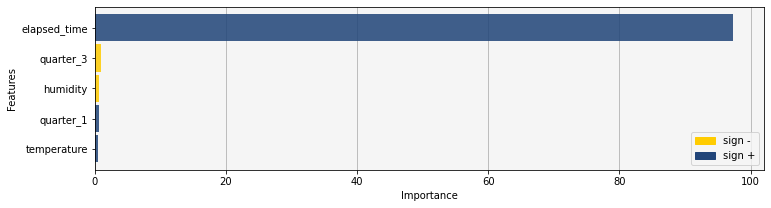

,importance
elapsed_time,97.26
quarter_3,1.01
humidity,0.71
quarter_1,0.58
temperature,0.43


<object>

In [53]:
model.fit(relation, predictors, response).features_importance()

Waw ! Our model is excellent. We can predict well the Energy consumption in households per region. If the real value is far from the model, we can raise an alert. We could then regulate the distributed electricity per region.

## Conclusion

We have solved this use-case in a pandas-like way but we never loaded the data in memory. This example showed an overview of the library. You can now start your own project by looking at the documentation first &#128521;